In [1]:
import pandas as pd
import tensorflow as tf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

import ydf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score  # Default metric, can be changed
from typing import Callable, List, Tuple

import genetic_algorithm

In [2]:
df = pd.read_excel("Data.xlsx", skiprows=5)
target_df = pd.read_excel("target.xlsx")

print(target_df['^GSPC'].isna().sum())



0


In [3]:
def analyze_acf_pacf(time_series, lags=30):
    plt.figure(figsize=(12, 6))

    # Plot ACF
    plt.subplot(1, 2, 1)
    plot_acf(time_series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')

    # Plot PACF
    plt.subplot(1, 2, 2)
    plot_pacf(time_series, lags=lags, ax=plt.gca(), method='ywmle') # Using ywmle for PACF calculation
    plt.title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()
    
def create_lag_features(df, lags):
    numerical_cols = df.select_dtypes(include=['number']).columns
    
    if isinstance(lags, int):
        lags = range(1, lags + 1)

    for col in numerical_cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def create_difference_then_lag_features(df, lags):
    numerical_cols = df.select_dtypes(include=['number']).columns
    df_lagged = df.copy()  # Create a copy to avoid modifying the original DataFrame in place

    if isinstance(lags, int):
        lags = range(1, lags + 1)

    for col in numerical_cols:
        df_lagged[f'{col}_diff'] = df_lagged[col].diff()
        
        for lag in lags:
            df_lagged[f'{col}_diff_lag_{lag}'] = df_lagged[f'{col}_diff'].shift(lag)


    return df_lagged

def create_date_features(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])

    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    # You can add more features like 'quarter
    return df

In [4]:
adf_result = adfuller(target_df['^GSPC'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

def check_stationarity(df):
    """
    Applies the Augmented Dickey-Fuller test to all columns of a DataFrame
    and prints out the columns that are not stationary at a significance level of 0.05.

    Args:
        df (pd.DataFrame): The DataFrame containing the features.
    """
    non_stationary_columns = []
    alpha = 0.05  # Significance level

    print("ADF Test Results:")
    for column in df.columns:
        if column == 'date':
            continue
        else:
            try:
                # Perform ADF test
                adf_result = adfuller(df[column], autolag='AIC')

                # Extract p-value
                p_value = adf_result[1]

                print(f"Column: {column}")
                print(f"  ADF Statistic: {adf_result[0]:.4f}")
                print(f"  p-value: {p_value:.4f}")
                print("  Critical Values:")
                for key, value in adf_result[4].items():
                    print(f"    {key}: {value:.4f}")

                # Check if the time series is stationary
                if p_value > alpha:
                    non_stationary_columns.append(column)
                    print(f"  Conclusion: {column} is likely NOT stationary (p-value > {alpha}).")
                else:
                    print(f"  Conclusion: {column} is likely stationary (p-value <= {alpha}).")
                print("-" * 30)

            except Exception as e:
                print(f"Error applying ADF test to column '{column}': {e}")
                print("-" * 30)

    if non_stationary_columns:
        print("\nColumns that are likely NOT stationary (at a significance level of 0.05):")
        for col in non_stationary_columns:
            print(f"- {col}")
        return non_stationary_columns
    else:
        print("\nAll columns are likely stationary (at a significance level of 0.05).")
        
print("--- Checking Stationarity in Features ---")
non_stationary_columns = check_stationarity(df)
print(f"Number of Cols: {len(non_stationary_columns)}")

  


ADF Statistic: 2.5309355721515447
p-value: 0.9990591518781804
--- Checking Stationarity in Features ---
ADF Test Results:
Column: PI-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Income
  ADF Statistic: 2.9870
  p-value: 1.0000
  Critical Values:
    1%: -3.4535
    5%: -2.8717
    10%: -2.5722
  Conclusion: PI-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Income is likely NOT stationary (p-value > 0.05).
------------------------------
Column: PSAVERT-Percent, Seasonally Adjusted Annual Rate-Personal Saving Rate
  ADF Statistic: -3.0090
  p-value: 0.0341
  Critical Values:
    1%: -3.4536
    5%: -2.8718
    10%: -2.5722
  Conclusion: PSAVERT-Percent, Seasonally Adjusted Annual Rate-Personal Saving Rate is likely stationary (p-value <= 0.05).
------------------------------
Column: PCE-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Consumption Expenditures
  ADF Statistic: 2.3917
  p-value: 0.9990
  Critical Values:
    1%: -3.4534
    5%: 

In [5]:
differenced_df = df.copy()
for col in non_stationary_columns:
  differenced_df[f'{col}_diff'] = differenced_df[col].diff()
  
for col in non_stationary_columns:
    if f'{col}_diff' in differenced_df.columns:
        from statsmodels.tsa.stattools import adfuller
        def check_stationarity(series, column_name):
            result = adfuller(series.dropna(), autolag='AIC')
            print(f'ADF Test for: {column_name}')
            print(f'  ADF Statistic: {result[0]:.4f}')
            print(f'  p-value: {result[1]:.4f}')
            print('  Critical Values:')
            for key, value in result[4].items():
                print(f'    {key}: {value:.4f}')
            if result[1] <= 0.05:
                print(f'  Conclusion: {column_name} is likely stationary.')
            else:
                print(f'  Conclusion: {column_name} is likely NOT stationary.')
            print('-' * 30)
        check_stationarity(differenced_df[f'{col}_diff'], f'{col}_diff')

ADF Test for: PI-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Income_diff
  ADF Statistic: -3.9805
  p-value: 0.0015
  Critical Values:
    1%: -3.4535
    5%: -2.8717
    10%: -2.5722
  Conclusion: PI-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Income_diff is likely stationary.
------------------------------
ADF Test for: PCE-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Consumption Expenditures_diff
  ADF Statistic: -4.4462
  p-value: 0.0002
  Critical Values:
    1%: -3.4534
    5%: -2.8717
    10%: -2.5722
  Conclusion: PCE-Billions of Dollars, Seasonally Adjusted Annual Rate-Personal Consumption Expenditures_diff is likely stationary.
------------------------------
ADF Test for: CPIAUCSL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items in U.S. City Average_diff
  ADF Statistic: -2.6301
  p-value: 0.0869
  Critical Values:
    1%: -3.4538
    5%: -2.8718
    10%: -2.5723
  Conclusion:

In [6]:
def apply_second_order_differencing(df, columns):
    """Applies second-order differencing to the specified columns."""
    for col in columns:
        if f'{col}_diff' in df.columns:
            df[f'{col}_diff_2'] = df[f'{col}_diff'].diff().dropna()
        else:
            print(f"First-order differenced column '{col}_diff' not found.")
    return df

# Assuming 'df_differenced' is your DataFrame after first-order differencing
# and 'non_stationary_columns' is your original list
remaining_cols = ["CPIAUCSL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items in U.S. City Average",
                  "CPILFESL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average",
                  "AHETPI-Dollars per Hour, Seasonally Adjusted-Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private"]
df_differenced_2 = apply_second_order_differencing(differenced_df.copy(), remaining_cols)


# Remember to re-run the ADF test on the '_diff_2' columns
for col in remaining_cols:
    if f'{col}_diff_2' in df_differenced_2.columns:
        from statsmodels.tsa.stattools import adfuller
        def check_stationarity(series, column_name):
            result = adfuller(series.dropna(), autolag='AIC')
            print(f'ADF Test for: {column_name}')
            print(f'  ADF Statistic: {result[0]:.4f}')
            print(f'  p-value: {result[1]:.4f}')
            print('  Critical Values:')
            for key, value in result[4].items():
                print(f'    {key}: {value:.4f}')
            if result[1] <= 0.05:
                print(f'  Conclusion: {column_name} is likely stationary.')
            else:
                print(f'  Conclusion: {column_name} is likely NOT stationary.')
            print('-' * 30)
        check_stationarity(df_differenced_2[f'{col}_diff_2'], f'{col}_diff_2')


ADF Test for: CPIAUCSL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items in U.S. City Average_diff_2
  ADF Statistic: -7.6452
  p-value: 0.0000
  Critical Values:
    1%: -3.4538
    5%: -2.8718
    10%: -2.5723
  Conclusion: CPIAUCSL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items in U.S. City Average_diff_2 is likely stationary.
------------------------------
ADF Test for: CPILFESL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average_diff_2
  ADF Statistic: -5.3925
  p-value: 0.0000
  Critical Values:
    1%: -3.4537
    5%: -2.8718
    10%: -2.5722
  Conclusion: CPILFESL-Index 1982-1984=100, Seasonally Adjusted-Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average_diff_2 is likely stationary.
------------------------------
ADF Test for: AHETPI-Dollars per Hour,

In [7]:
print(df.shape)
print(differenced_df.shape)
df_differenced_2
print(df_differenced_2.shape)

(298, 43)
(298, 72)
(298, 75)


In [8]:
lagged_df = create_lag_features(df_differenced_2.copy(), 2)
print(lagged_df.shape)

(298, 223)


In [9]:
time_features = create_date_features(lagged_df.copy(), 'date')
final_features = time_features.set_index('date')
final_target = target_df.set_index('date')
print(final_features.index)
print(final_target.index)
print(final_features.shape)

DatetimeIndex(['2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01',
               '2001-01-01', '2001-02-01',
               ...
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01'],
              dtype='datetime64[ns]', name='date', length=298, freq=None)
DatetimeIndex(['2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01',
               '2001-01-01', '2001-02-01',
               ...
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01'],
              dtype='datetime64[ns]', name='date', length=298, freq=None)
(298, 224)


In [10]:
def nested_time_series_cv_5_folds_ydf(
    model_params: dict,  # Pass hyperparameters as a dictionary
    algo_name: str,  # For clarity in output
    data_folds: List[Tuple[pd.DataFrame, pd.Series]],
    grid: dict,  # Hyperparameter grid is not directly used with YDF in this way
    metric: Callable[[pd.Series, pd.Series], float] = roc_auc_score
) -> float:
    """
    Implements the Nested Time-Series (NTS) Cross-Validation Algorithm for YDF Random Forest with 5 folds.

    Args:
        model_params: A dictionary of base hyperparameters for the YDF RandomForestClassifier.
        algo_name: Name of the algorithm (e.g., "YDF Random Forest").
        data_folds: A list of tuples, where each tuple contains a DataFrame of features (X)
                    and a Series of the target variable (Y) for each of the k=5 folds,
                    ordered chronologically by business cycle.
        grid: A dictionary where keys are hyperparameter names of YDF RandomForestClassifier
              and values are lists of hyperparameter values to search.
        metric: A callable function that takes true target values (y_true) and predicted
                target values (y_pred) and returns a performance score. Defaults to AUC-ROC.

    Returns:
        performance: The average forecast performance estimate across the outer loop iterations.
    """
    k = len(data_folds)
    outer_scores = []

    if k != 5:
        raise ValueError(f"Expected 5 data folds, but received {k}.")

    for i in range(2, k - 1):  # Outer loop from i = 3 to k-1 (using 0-based indexing, so 2 to 3 for k=5)
        print(f"\n--- Outer Loop Iteration: {i + 1} ---")

        # Hold out data fold i + 1 for use as an outer loop test set
        test_fold_index = i + 1
        if test_fold_index >= k:
            print(f"Skipping iteration {i+1} as test fold index {test_fold_index} is out of bounds.")
            continue
        X_outer_test, y_outer_test = data_folds[test_fold_index]
        print(f"Outer Test Fold: {test_fold_index + 1}")

        # Use data folds 1 to i as an outer loop training set
        outer_train_folds = data_folds[:i + 1]
        X_outer_train = pd.concat([fold[0] for fold in outer_train_folds])
        y_outer_train = pd.concat([fold[1] for fold in outer_train_folds])
        print(f"Outer Train Folds: 1 to {i + 1}")

        # Stratify and shuffle outer loop training set and divide into 3 folds
        n_inner_folds = 3
        skf = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=42)  # Added random_state for reproducibility
        inner_fold_indices = list(skf.split(X_outer_train, y_outer_train))

        hyperparameter_scores = {}

        # HYPERPARAMETER GRID SEARCH
        param_names = list(grid.keys())
        param_values = list(grid.values())

        from itertools import product
        param_combinations = list(product(*param_values))

        print("Starting Hyperparameter Grid Search...")

        for j_idx, params_tuple in enumerate(param_combinations):
            params = dict(zip(param_names, params_tuple))
            print(f"\n  --- Hyperparameter Combination {j_idx + 1}/{len(param_combinations)}: {params} ---")
            inner_scores = []

            # INNER LOOP (standard 3-fold stratified/shuffled cross-validation)
            for m in range(n_inner_folds):
                print(f"    --- Inner Loop Fold: {m + 1} ---")
                train_indices, test_indices = inner_fold_indices[m]
                X_inner_train, X_inner_test = X_outer_train.iloc[train_indices], X_outer_train.iloc[test_indices]
                y_inner_train, y_inner_test = y_outer_train.iloc[train_indices], y_outer_train.iloc[test_indices]

                # Convert pandas DataFrames to YDF format
                inner_train_ds = ydf.pd_dataframe_to_dataset(pd.concat([X_inner_train, y_inner_train], axis=1), label=y_inner_train.name if isinstance(y_inner_train, pd.Series) else 'target')
                inner_test_ds = ydf.pd_dataframe_to_dataset(X_inner_test)

                # Estimate a classifier for model using algo, the inner loop train set and hyperparameters j
                current_model = ydf.RandomForestClassifier(random_seed=42, **model_params, **params) # Apply hyperparameters
                current_model.fit(inner_train_ds)

                # inner score[m] ← calculate forecast performance for inner loop m using metric and the inner loop test set
                predictions = current_model.predict(inner_test_ds)
                # YDF predictions might be in a different format, extract probabilities if needed
                y_inner_pred = predictions.probabilities[:, 1] if hasattr(predictions, 'probabilities') else predictions.classes
                inner_score = metric(y_inner_test, y_inner_pred)
                inner_scores.append(inner_score)
                print(f"      Inner Score (Fold {m + 1}): {inner_score:.4f}")

            # hyperparameter score[j] ← average of inner score[1:3] for hyperparameters j
            avg_inner_score = np.mean(inner_scores)
            hyperparameter_scores[params_tuple] = avg_inner_score
            print(f"    Average Inner Score for this Hyperparameter Combination: {avg_inner_score:.4f}")

        # optimal hyperparameters[i] ← element in grid with the highest hyperparameter score
        best_hyperparams_tuple = max(hyperparameter_scores, key=hyperparameter_scores.get)
        optimal_hyperparameters = dict(zip(param_names, best_hyperparams_tuple))
        print(f"\nOptimal Hyperparameters for Outer Loop Iteration {i + 1}: {optimal_hyperparameters}")

        # Estimate a classifier for model using algo, the outer loop train set and optimal hyperparameters[i]
        outer_train_ds = ydf.pd_dataframe_to_dataset(pd.concat([X_outer_train, y_outer_train], axis=1), label=y_outer_train.name if isinstance(y_outer_train, pd.Series) else 'target')
        outer_test_ds = ydf.pd_dataframe_to_dataset(X_outer_test)

        final_model = ydf.RandomForestClassifier(random_seed=42, **model_params, **optimal_hyperparameters)
        final_model.fit(outer_train_ds)

        # outer score[i] ← calculate forecast performance for outer loop i using metric and the outer loop test set
        predictions = final_model.predict(outer_test_ds)
        y_outer_pred = predictions.probabilities[:, 1] if hasattr(predictions, 'probabilities') else predictions.classes
        outer_score = metric(y_outer_test, y_outer_pred)
        outer_scores.append(outer_score)
        print(f"Outer Score (Fold {test_fold_index + 1}): {outer_score:.4f}")

    # performance ← average of outer scores[3:k] (using 0-based indexing, this is from index 2 to k-2)
    performance = np.mean(outer_scores)
    print(f"\n--- Final {algo_name} Performance (Average of Outer Scores): {performance:.4f} ---")
    return performance

In [11]:
if 'Unnamed: 0' in final_features.columns:
  print("WHY OH GOD WHY")
  final_features = final_features.drop(columns=['Unnamed: 0'])

In [23]:
best_chromosome, best_score, best_scores = genetic_algorithm.genetic_algorithm_feature_selection(final_features, final_target, metric="R2", verbose=False, early_stopping_rounds=None)

Train model on 208 examples
Model trained in 0:00:00.071928
Train model on 208 examples
Model trained in 0:00:00.068893
Train model on 208 examples
Model trained in 0:00:00.097868
Train model on 208 examples
Model trained in 0:00:00.065394
Train model on 208 examples
Model trained in 0:00:00.069872
Train model on 208 examples
Model trained in 0:00:00.062867
Train model on 208 examples
Model trained in 0:00:00.061778
Train model on 208 examples
Model trained in 0:00:00.061401
Train model on 208 examples
Model trained in 0:00:00.062558
Train model on 208 examples
Model trained in 0:00:00.068993
Train model on 208 examples
Model trained in 0:00:00.057874
Train model on 208 examples
Model trained in 0:00:00.061934
Train model on 208 examples
Model trained in 0:00:00.080335
Train model on 208 examples
Model trained in 0:00:00.066805
Train model on 208 examples
Model trained in 0:00:00.075527
Train model on 208 examples
Model trained in 0:00:00.059206
Train model on 208 examples
Model traine

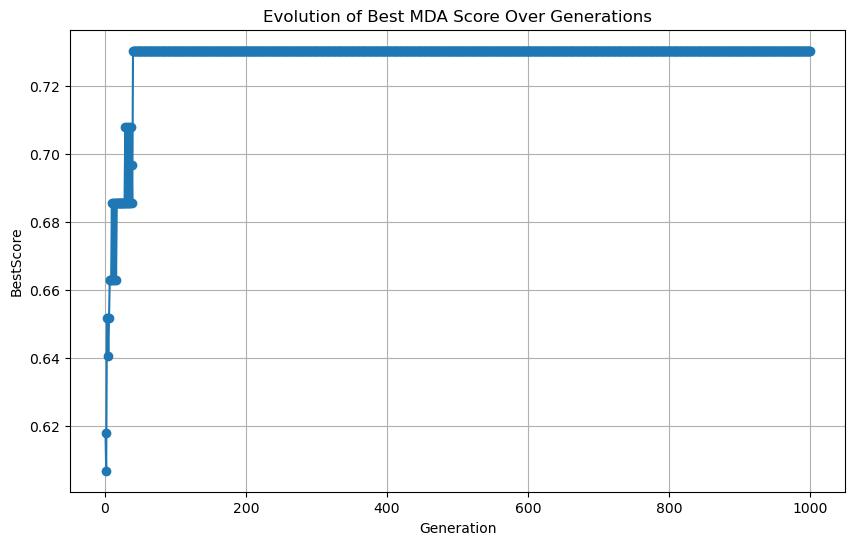

In [26]:
import matplotlib.pyplot as plt

# Assuming you have run your genetic algorithm and have the 'best_scores' list

# Create a list of generation numbers for the x-axis
generations = range(1, len(best_scores) + 1)

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(generations, best_scores, marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Generation")
plt.ylabel("BestScore")  # Assuming you are using MSE
plt.title("Evolution of Best MDA Score Over Generations")
plt.grid(True)

# Show the plot
plt.show()

In [30]:
features = genetic_algorithm.data_chromosome_subset(final_features, best_chromosome)
features.to_excel("features-2.0.xlsx")
